In [1]:
# - Good topic and a very clear project goal. Good job!

# - 2-4 users for each group is too low. I can't imagine they will post Climate change topics all the time. 
# I think you need at least 100 people for each group to gain enough data.

# - After your initial collection and obtained a list of users, I recommend crawling a list of tweets for
# each user to expand your dataset.

# - I don't understand the "various probabilities". Not sure what you can infer from it. 
# Maybe show the probability of word use? Like, do users of different groups likely to use different words
# to describe the same topic? Are they using different hashtags? What is the probability of being retweeted?

# - Regarding the second data source. You can consider data related to the climate-disaster.
# E.g. data of wildfire/flood etc. And see how different groups react to those disasters.

In [2]:
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tweepy
import json
import time
import string
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sn
import datetime as datetime
from collections import Counter
from matplotlib import pyplot as plt
import math
import numpy as np
from collections import defaultdict
from datetime import datetime
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import gensim
from gensim.models import Phrases
from textblob import TextBlob
np.seterr(divide='ignore', invalid='ignore')

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")


consumer_key="FpWPF7k27tXUJTnsSFHjvHOw2"
consumer_secret="VLwfJNfdmvpUmZ1m7So7VKqL9eEOWfYiuQc7L01HmJWd3RDGcp"
access_token="2982863656-PcWj89Z3sxUTXBrDPisee3rx2oDQnK9KXks8gqJ"
access_token_secret="64yFpikvW2FfXvBlbyrG6ZDmUOQv9t32d1SSlL4kTFToa"

auth=tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api=tweepy.API(auth)

public_tweets=api.home_timeline()
tweets=[]
for tweet in public_tweets:
#     print(tweet.text)
    tweets.append(tweet._json)
print(json.dumps(tweets[0]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{"created_at": "Fri Dec 04 12:24:22 +0000 2020", "id": 1334835939798036490, "id_str": "1334835939798036490", "text": "Warner Bros. will make all of their 2021 films, including \u201cDune\u201d and \u201cMatrix 4\" available on HBO Max at the same ti\u2026 https://t.co/PxXruSx20M", "truncated": true, "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": [{"url": "https://t.co/PxXruSx20M", "expanded_url": "https://twitter.com/i/web/status/1334835939798036490", "display_url": "twitter.com/i/web/status/1\u2026", "indices": [117, 140]}]}, "source": "<a href=\"https://studio.twitter.com\" rel=\"nofollow\">Twitter Media Studio</a>", "in_reply_to_status_id": null, "in_reply_to_status_id_str": null, "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "in_reply_to_screen_name": null, "user": {"id": 3108351, "id_str": "3108351", "name": "The Wall Street Journal", "screen_name": "WSJ", "location": "New York, NY", "description": "Sign up for our newsletters and email al

In [3]:
def crawl_tweet(file_name="raw_tweet.json", search_key="screen_name", max_tweet=300):
    print(search_key)
    tweet_count=0
    max_id=-1
    with open(file_name, "w+") as fp: # overwrite old data
        fp.write("")
    while tweet_count<max_tweet:
        try:
            # tweet crawling
            if max_id<0:
                new_tweets=api.user_timeline(screen_name=search_key, count=50)
            else:
                new_tweet=api.user_timeline(screen_name=search_key, count=50, max_id=str(max_id-1))
            if not new_tweets:
                print("no more tweets available")
                break
            with open(file_name, "a") as fp:
                for tweet in new_tweets:
                    fp.write(json.dumps(tweet._json)+"\n")
            max_id=new_tweets[-1].id
            tweet_count+=len(new_tweets)
            print(f"{tweet_count} tweets have been downloaded")
        except tweepy.TweepError as e:
            print(str(e))
            break


In [157]:
# CEO Group

CEO_screen_name=["@Benioff", "@richardbranson", "@Bill_Gross", "@chrisbrogan", "@briansolis", "@Jon_Ferrara", "@mcuban", 
           "@jack", "@levie", "@SteveCase","@rwang0", "@RomanStanek", "@SteveForbesCEO", "@TimO_reilly", "@elonmusk", "@bhalligan", 
           "@MichaelDell", "@PeterAceto", "@WendySLea", "@BillGates", "@shervin", "@MickyArison", "@markfidelman", "@marissamayer",
           "@AndrewGrill", "@aneelb", "@mtbert", "@kevinrose", "@bryankramer", "@dens", "@dickc", 
           "@davemorin", "@Manpowergroupjj", "@MichelleRhee", "@invoker", "@davidkarp", "@drewhouston", "@jeffweiner", 
           "@jeremys", "@eldsjal", "@garyknell", "@AmFamJack", "@peretti", "@andrewmason", "@westernunionCEO", "@JeffBezos",
           "@tim_cook", "@markzucky", "@satyanadella", "@sundarpichai", "@mtbarra"]
            
crawl_tweet(file_name="Marc_Benioff.json", search_key="@Benioff", max_tweet=300)
crawl_tweet(file_name="Richard_Branson.json", search_key="@richardbranson")
crawl_tweet(file_name="Bill_Gross.json", search_key="@Bill_Gross")
crawl_tweet(file_name="Chris_Brogan.json", search_key="@chrisbrogan")
crawl_tweet(file_name="Brian_Solis.json", search_key="@briansolis")
crawl_tweet(file_name="Jon_Ferrara.json", search_key="@Jon_Ferrara")
crawl_tweet(file_name="Mark_Cuban.json", search_key="@mcuban")
crawl_tweet(file_name="Jack_Dorsey.json", search_key="@jack")
crawl_tweet(file_name="Aaron_Levie.json", search_key="@levie")
crawl_tweet(file_name="Steve_Case.json", search_key="@SteveCase")
crawl_tweet(file_name="Ray_Wang.json", search_key="@rwang0")
crawl_tweet(file_name="Roman_Stanek.json", search_key="@RomanStanek")
crawl_tweet(file_name="Steve_Forbes.json", search_key="@SteveForbesCEO")
crawl_tweet(file_name="Tim_O'Reilly.json", search_key="@TimO_reilly")
crawl_tweet(file_name="Elon_Musk.json", search_key="@elonmusk")
crawl_tweet(file_name="Brian_Halligan.json", search_key="@bhalligan")
crawl_tweet(file_name="Michael_Dell.json", search_key="@MichaelDell")
crawl_tweet(file_name="Peter_Aceto.json", search_key="@PeterAceto")
crawl_tweet(file_name="Wendy_S_Lea.json", search_key="@WendySLea")
crawl_tweet(file_name="Bill_Gates.json", search_key="@BillGates")
crawl_tweet(file_name="Shervin_Pishever.json", search_key="@shervin")
crawl_tweet(file_name="Micky_Arison.json", search_key="@MickyArison")
crawl_tweet(file_name="Mark_Fidelmen.json", search_key="@markfidelman")
crawl_tweet(file_name="Marissa_Mayer.json", search_key="@marissamayer")
crawl_tweet(file_name="Andrew_Grill.json", search_key="@AndrewGrill")
crawl_tweet(file_name="Aneel_Bhusri.json", search_key="@aneelb")
crawl_tweet(file_name="Mark_Bertolini.json", search_key="@mtbert")
crawl_tweet(file_name="Kevin_Rose.json", search_key="@kevinrose")
crawl_tweet(file_name="Bryan_Kramer.json", search_key="@bryankramer")
crawl_tweet(file_name="Dennis_Crowley.json", search_key="@dens")
crawl_tweet(file_name="Dick_Costolo.json", search_key="@dickc")
crawl_tweet(file_name="Dave_Morin.json", search_key="@davemorin")
crawl_tweet(file_name="Jeffery_Joerres.json", search_key="@Manpowergroupjj")
crawl_tweet(file_name="Ryan_Holmes.json", search_key="@invoker")
crawl_tweet(file_name="David_Karp.json", search_key="@davidkarp")
crawl_tweet(file_name="Drew_Houston.json", search_key="@drewhouston")
crawl_tweet(file_name="Jeff_Weiner.json", search_key="@jeffweiner")
crawl_tweet(file_name="Jeremy_Stoppelman.json", search_key="@jeremys")
crawl_tweet(file_name="Daneil_Ek.json", search_key="@eldsjal")
crawl_tweet(file_name="Gary_Knell.json", search_key="@garyknell")
crawl_tweet(file_name="Jack_Salzwedel.json", search_key="@AmFamJack")
crawl_tweet(file_name="Jonah_Peretti.json", search_key="@peretti")
crawl_tweet(file_name="Andrew_Mason.json", search_key="@andrewmason")
crawl_tweet(file_name="Hikmet_Ersek.json", search_key="@westernunionCEO")
crawl_tweet(file_name="Jeff_Bezos.json", search_key="@JeffBezos")
crawl_tweet(file_name="Tim_Cook.json", search_key="@tim_cook")
crawl_tweet(file_name="Mark_Zuckerburg.json", search_key="@markzucky")
crawl_tweet(file_name="Satya_Nadella.json", search_key="@satyanadella")
crawl_tweet(file_name="Sundar_Pichai.json", search_key="@sundarpichai")
crawl_tweet(file_name="Mary_Barra.json", search_key="@mtbarra")

@Benioff
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@richardbranson
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@Bill_Gross
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@chrisbrogan
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@briansolis
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have

100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@AmFamJack
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@peretti
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@andrewmason
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@westernunionCEO
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@JeffBezos
49 tweets have 

In [158]:
# Celebrities Group
Celebrities_screen_name=["@taylorswift13", "@justinbieber", "@katyperry", "@rihanna", "@ladygaga", "@TheEllenShow", "@ArianaGrande",
                        "@ddlovato", "@jimmyfallon", "@Oprah", "@KevinHart4real", "@LilTunechi", "@jtimberlake", "@Pink", "@ConanOBrien",
                        "@ActuallyNPH", "@ShawnMendes", "@pitbull", "@arrahman", "@coldplay", "@Eminem", "@AvrilLavigne", "@davidguetta", 
                        "@ricky_martin", "@LeoDiCaprio", "@MarkRuffalo", "@HamillHimself", "@RobertDowneyJr", "@GeorgeTakei", "@lukecombs",
                        "@HardyMusic", "@ianndior", "@McConaughey", "@jimmykimmel", "@BenAffleck", "@KidCudi", "@kanyewest", "@thekidlaroi", 
                        "@Louis_Tomlinson", "@marshmellomusic", "@ILLENIUM", "@aplusk", "@SnoopDogg", "@BarackObama", "@aliciakeys", 
                         "@MichelleObama", "@TheRock", "@JohnCena", "@MikeTyson", "@Casey"]



crawl_tweet(file_name="TaylorSwift.json", search_key="@taylorswift13", max_tweet=300)
crawl_tweet(file_name="JustinBeiber.json", search_key="@justinbieber")
crawl_tweet(file_name="KatyPerry.json", search_key="@katyperry")
crawl_tweet(file_name="Rihanna.json", search_key="@rihanna")
crawl_tweet(file_name="LadyGaga.json", search_key="@ladygaga")
crawl_tweet(file_name="EllenDeGeneres.json", search_key="@TheEllenShow")
crawl_tweet(file_name="ArianaGrande.json", search_key="@ArianaGrande")
crawl_tweet(file_name="DemiLovato.json", search_key="@ddlovato")
crawl_tweet(file_name="JimmyFallon.json", search_key="@jimmyfallon")
crawl_tweet(file_name="OprahWinfrey.json", search_key="@Oprah")
crawl_tweet(file_name="KevinHart.json", search_key="@KevinHart4real")
crawl_tweet(file_name="LilWayne.json", search_key="@LilTunechi")
crawl_tweet(file_name="JustinTimberlake.json", search_key="@jtimberlake")
crawl_tweet(file_name="P!nk.json", search_key="@Pink")
crawl_tweet(file_name="ConanOBrien.json", search_key="@ConanOBrien")
crawl_tweet(file_name="NeilPatrickHarris.json", search_key="@ActuallyNPH")
crawl_tweet(file_name="ShawnMendes.json", search_key="@ShawnMendes")
crawl_tweet(file_name="Pitbull.json", search_key="@pitbull")
crawl_tweet(file_name="A.R.Rahman.json", search_key="@arrahman")
crawl_tweet(file_name="Coldplay.json", search_key="@coldplay")
crawl_tweet(file_name="MarshallMathers.json", search_key="@Eminem")
crawl_tweet(file_name="AvrilLavigne.json", search_key="@AvrilLavigne")
crawl_tweet(file_name="DavidGuetta.json", search_key="@davidguetta")
crawl_tweet(file_name="RickyMartin.json", search_key="@ricky_martin")
crawl_tweet(file_name="LeonardoDiCaprio.json", search_key="@LeoDiCaprio")
crawl_tweet(file_name="MarkRuffalo.json", search_key="@MarkRuffalo")
crawl_tweet(file_name="MarkHamill.json", search_key="@HamillHimself")
crawl_tweet(file_name="RobertDowneyJr.json", search_key="@RobertDowneyJr")
crawl_tweet(file_name="GeorgeTakei.json", search_key="@GeorgeTakei")
crawl_tweet(file_name="LukeCombs.json", search_key="@lukecombs")
crawl_tweet(file_name="HARDY.json", search_key="@HardyMusic")
crawl_tweet(file_name="ianndior.json", search_key="@ianndior")
crawl_tweet(file_name="MatthewMcConaughey.json", search_key="@McConaughey")
crawl_tweet(file_name="JimmyKimmel.json", search_key="@jimmykimmel")
crawl_tweet(file_name="BenAffleck.json", search_key="@BenAffleck")
crawl_tweet(file_name="KidCudi.json", search_key="@KidCudi")
crawl_tweet(file_name="KanyeWest.json", search_key="@kanyewest")
crawl_tweet(file_name="CharltonHoward.json", search_key="@thekidlaroi")
crawl_tweet(file_name="LouisTomlinson.json", search_key="@Louis_Tomlinson")
crawl_tweet(file_name="Marshmello.json", search_key="@marshmellomusic")
crawl_tweet(file_name="ILLENIUM.json", search_key="@ILLENIUM")
crawl_tweet(file_name="ashtonkutcher.json", search_key="@aplusk")
crawl_tweet(file_name="SnoopDogg.json", search_key="@SnoopDogg")
crawl_tweet(file_name="BarackObama.json", search_key="@BarackObama")
crawl_tweet(file_name="AliciaKeys.json", search_key="@aliciakeys")
crawl_tweet(file_name="MichelleObama.json", search_key="@MichelleObama")
crawl_tweet(file_name="DwayneJohnson.json", search_key="@TheRock")
crawl_tweet(file_name="JohnCena.json", search_key="@JohnCena")
crawl_tweet(file_name="MikeTyson.json", search_key="@MikeTyson")
crawl_tweet(file_name="CaseyNeistat.json", search_key="@Casey")

@taylorswift13
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@justinbieber
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@katyperry
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@rihanna
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@ladygaga
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have be

150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@aplusk
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@SnoopDogg
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@BarackObama
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@aliciakeys
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@MichelleObama
50 tweets have been downloaded
100 tweets have be

In [159]:
# Politicians Group

# Democrats
crawl_tweet(file_name="JoeBiden.json", search_key="@JoeBiden", max_tweet=300)
crawl_tweet(file_name="AndrewCuomo.json", search_key="@NYGovCuomo")
crawl_tweet(file_name="ChuckSchumer.json", search_key="@SenSchumer")
crawl_tweet(file_name="DianneFeinstein.json", search_key="@SenFeinstein")
crawl_tweet(file_name="AmyKlobuchar.json", search_key="@amyklobuchar")
crawl_tweet(file_name="StaceyAbrams.json", search_key="@staceyabrams")
crawl_tweet(file_name="MaxineWaters.json", search_key="@RepMaxineWaters")
crawl_tweet(file_name="TedLieu.json", search_key="@tedlieu")
crawl_tweet(file_name="AdamSchiff.json", search_key="@RepAdamSchiff")
crawl_tweet(file_name="ChrisMurphy.json", search_key="@ChrisMurphyCT")
crawl_tweet(file_name="TimKaine.json", search_key="@timkaine")
crawl_tweet(file_name="NancyPelosi.json", search_key="@SpeakerPelosi")
crawl_tweet(file_name="RashidaTlaib.json", search_key="@RashidaTlaib")
crawl_tweet(file_name="GavinNewsom.json", search_key="@GavinNewsom")
crawl_tweet(file_name="JerryBrown.json", search_key="@JerryBrownGov")
crawl_tweet(file_name="EricSwalwell.json", search_key="@RepSwalwell")
crawl_tweet(file_name="ElijahCummings.json", search_key="@RepCummings")
crawl_tweet(file_name="BetoORourke.json", search_key="@BetoORourke")
crawl_tweet(file_name="MikeBloomberg.json", search_key="@MikeBloomberg")
crawl_tweet(file_name="JohnLewis.json", search_key="@repjohnlewis")
crawl_tweet(file_name="AlFranken.json", search_key="@alfranken")
crawl_tweet(file_name="BernieSanders.json", search_key="@BernieSanders")
crawl_tweet(file_name="ElizabethWarren.json", search_key="@SenWarren")
crawl_tweet(file_name="KamalaHarris.json", search_key="@KamalaHarris")
crawl_tweet(file_name="CoryBooker.json", search_key="@CoryBooker")

# Republicans
crawl_tweet(file_name="DonaldTrump.json", search_key="@realDonaldTrump")
crawl_tweet(file_name="MikePence.json", search_key="@VP")
crawl_tweet(file_name="MittRomney.json", search_key="@MittRomney")
crawl_tweet(file_name="TedCruz.json", search_key="@tedcruz")
crawl_tweet(file_name="GovChristie.json", search_key="@GovChristie")
crawl_tweet(file_name="KayleighMcEnany.json", search_key="@kayleighmcenany")
crawl_tweet(file_name="LindseyGraham.json", search_key="@LindseyGrahamSC")
crawl_tweet(file_name="MitchMcConnell.json", search_key="@senatemajldr")
crawl_tweet(file_name="JimJordan.json", search_key="@Jim_Jordan")
crawl_tweet(file_name="KevinMcCarthy.json", search_key="@GOPLeader")
crawl_tweet(file_name="RandPaul.json", search_key="@RandPaul")
crawl_tweet(file_name="MikeHuckabee.json", search_key="@GovMikeHuckabee")
crawl_tweet(file_name="MarcoRubio.json", search_key="@marcorubio")
crawl_tweet(file_name="MikeLee.json", search_key="@SenMikeLee")
crawl_tweet(file_name="ChuckGrassley.json", search_key="@ChuckGrassley")
crawl_tweet(file_name="KellyanneConway.json", search_key="@KellyannePolls")
crawl_tweet(file_name="PaulRyan.json", search_key="@SpeakerRyan")
crawl_tweet(file_name="AllenWest.json", search_key="@AllenWest")
crawl_tweet(file_name="TreyGowdy.json", search_key="@TGowdySC")
crawl_tweet(file_name="DevinNunes.json", search_key="@DevinNunes")
crawl_tweet(file_name="NewtGingrich.json", search_key="@newtgingrich")
crawl_tweet(file_name="JohnMcCain.json", search_key="@SenJohnMcCain")
crawl_tweet(file_name="DonaldTrumpJr.json", search_key="@DonaldJTrumpJr")
crawl_tweet(file_name="RonnaMcDaniel.json", search_key="@GOPChairwoman")
crawl_tweet(file_name="MattGaetz.json", search_key="@RepMattGaetz")

@JoeBiden
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@NYGovCuomo
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@SenSchumer
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@SenFeinstein
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@amyklobuchar
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have

100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@SpeakerRyan
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@AllenWest
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@TGowdySC
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@DevinNunes
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@newtgingrich
50 tweets have b

In [160]:
# Athletes
crawl_tweet(file_name="StephenCurry.json", search_key="@StephenCurry30", max_tweet=300)
crawl_tweet(file_name="KevinDurant.json", search_key="@KDTrey5")
crawl_tweet(file_name="LeBronJames.json", search_key="@KingJames")
crawl_tweet(file_name="ReggieBush.json", search_key="@ReggieBush")
crawl_tweet(file_name="TomBrady.json", search_key="@TomBrady")
crawl_tweet(file_name="DrewBrees.json", search_key="@drewbrees")
crawl_tweet(file_name="RussellWilson.json", search_key="@DangeRussWilson")
crawl_tweet(file_name="JJWatt.json", search_key="@JJWatt")
crawl_tweet(file_name="FloydMayweather.json", search_key="@FloydMayweather")
crawl_tweet(file_name="ConorMcGregor.json", search_key="@TheNotoriousMMA")
crawl_tweet(file_name="PatrickMahomes.json", search_key="@PatrickMahomes")
crawl_tweet(file_name="MikeTrout.json", search_key="@MikeTrout")
crawl_tweet(file_name="CameronNewton.json", search_key="@CameronNewton")
crawl_tweet(file_name="DavidPrice.json", search_key="@DAVIDprice24")
crawl_tweet(file_name="DavidOrtiz.json", search_key="@davidortiz")
crawl_tweet(file_name="ColinKaepernick.json", search_key="@Kaepernick7")
crawl_tweet(file_name="AlexOvechkin.json", search_key="@ovi8")
crawl_tweet(file_name="SerenaWilliams.json", search_key="@serenawilliams")
crawl_tweet(file_name="VenusWilliams.json", search_key="@Venuseswilliams")
crawl_tweet(file_name="JujuSmithSchuster.json", search_key="@TeamJuJu")
crawl_tweet(file_name="AbbyWambach.json", search_key="@AbbyWamBach")
crawl_tweet(file_name="AaronRodgers.json", search_key="@AaronRodgers12")
crawl_tweet(file_name="DezBryant.json", search_key="@DezBryant")
crawl_tweet(file_name="KlayThompson.json", search_key="@KlayThompson")
crawl_tweet(file_name="MesutOzil.json", search_key="@MesutOzil1088")
crawl_tweet(file_name="Shaq.json", search_key="@SHAQ")
crawl_tweet(file_name="RichardSherman.json", search_key="@RSherman_25")
crawl_tweet(file_name="RioFerdinand.json", search_key="@rioferdy5")
crawl_tweet(file_name="WayneRooney.json", search_key="@WayneRooney")
crawl_tweet(file_name="ArnoldSchwarzenegger.json", search_key="@Schwarzenegger")
crawl_tweet(file_name="ChrisPaul.json", search_key="@CP3")
crawl_tweet(file_name="DeionSanders.json", search_key="@COACHPRIME")
crawl_tweet(file_name="shannonsharpe.json", search_key="@ShannonSharpe")
crawl_tweet(file_name="StephenASmith.json", search_key="@stephenasmith")
crawl_tweet(file_name="PatrickMcEnroe.json", search_key="@PatrickMcEnroe")
crawl_tweet(file_name="GedeónGuardiola.json", search_key="@GedeonGuardiola")
crawl_tweet(file_name="AubreyBledsoe.json", search_key="@AubreyBledsoe")
crawl_tweet(file_name="CrystalDunnSoubrier.json", search_key="@crysdunn_19")
crawl_tweet(file_name="ZachErtz.json", search_key="@ZERTZ_86")
crawl_tweet(file_name="JulieJohnstonErtz.json", search_key="@julieertz")
crawl_tweet(file_name="AshlynHarris.json", search_key="@Ashlyn_Harris")
crawl_tweet(file_name="AliKrieger.json", search_key="@alikrieger")
crawl_tweet(file_name="AliRiley.json", search_key="@RileyThree")
crawl_tweet(file_name="LaurenFendrick.json", search_key="@LaurenFendrick")
crawl_tweet(file_name="KendrickPerkins.json", search_key="@KendrickPerkins")
crawl_tweet(file_name="AlexRodriguez.json", search_key="@AROD")
crawl_tweet(file_name="IsaiahThomas.json", search_key="@isaiahthomas")
crawl_tweet(file_name="MorganBrianGautrat.json", search_key="@moeebrian")
crawl_tweet(file_name="CarliLloyd.json", search_key="@CarliLloyd")
crawl_tweet(file_name="BakerMayfield.json", search_key="@bakermayfield")


@StephenCurry30
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@KDTrey5
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@KingJames
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@ReggieBush
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@TomBrady
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have bee

50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@alikrieger
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@RileyThree
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@LaurenFendrick
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been downloaded
@KendrickPerkins
50 tweets have been downloaded
100 tweets have been downloaded
150 tweets have been downloaded
200 tweets have been downloaded
250 tweets have been downloaded
300 tweets have been

In [3]:
def jprint(data):
    print(json.dumps(data, indent=4))
# jprint(data)  

def load_json(file_name): # function to load json file
    result=[]
    with open(file_name, 'r', encoding="utf-8") as fp: # open file
        line=fp.readline()   # read line 
        while line: # runs for all the lines in the file
            tobj=json.loads(line)  # loads line 
            d={                                 # dictionary that grabs the data needed and formats it for the data frame
                "created_at":tobj["created_at"],
                "id_str":tobj["id_str"],
                "text":tobj["text"],
                "favorite_count":tobj["favorite_count"],
                "retweet_count":tobj["retweet_count"],
                "user_id_str":tobj["user"]["id_str"],
                "name":tobj["user"]["name"],
                "screen_name":tobj["user"]["screen_name"],
                "user_location":tobj["user"]["location"],
                "user_description":tobj["user"]["description"],
                "user_friends_count":tobj["user"]["friends_count"],
                "user_followers_count":tobj["user"]["followers_count"],
                "hashtags":"|".join(sorted([d["text"] for d in tobj["entities"]["hashtags"]])),
                "mentions":"|".join(sorted([d["screen_name"] for d in tobj["entities"]["user_mentions"]]))
            }
            result.append(d)
            line=fp.readline()
    return result



In [4]:
#CEOs Group

MarcBenioff=load_json("Marc_Benioff.json")
RichardBranson=load_json("Richard_Branson.json")
BillGross=load_json("Bill_Gross.json")
ChrisBrogan=load_json("Chris_Brogan.json")
BrianSolis=load_json("Brian_Solis.json")
JonFerrara=load_json("Jon_Ferrara.json")
MarkCuban=load_json("Mark_Cuban.json")
JackDorsey=load_json("Jack_Dorsey.json")
AaronLevie=load_json("Aaron_Levie.json")
SteveCase=load_json("Steve_Case.json")
RayWang=load_json("Ray_Wang.json")
RomanStanek=load_json("Roman_Stanek.json")
SteveForbes=load_json("Steve_Forbes.json")
TimOreilly=load_json("Tim_O'Reilly.json")
ElonMusk=load_json("Elon_Musk.json")
BrianHalligan=load_json("Brian_Halligan.json")
MichaelDell=load_json("Michael_Dell.json")
PeterAceto=load_json("Peter_Aceto.json")
WendySLea=load_json("Wendy_S_Lea.json")
BillGates=load_json("Bill_Gates.json")
ShervinPishever=load_json("Shervin_Pishever.json")
MickyArison=load_json("Micky_Arison.json")
MarkFidelmen=load_json("Mark_Fidelmen.json")
MarissaMayer=load_json("Marissa_Mayer.json")
AndrewGrill=load_json("Andrew_Grill.json")
AneelBhusri=load_json("Aneel_Bhusri.json")
MarkBertolini=load_json("Mark_Bertolini.json")
KevinRose=load_json("Kevin_Rose.json")
BryanKramer=load_json("Bryan_Kramer.json")
DennisCrowley=load_json("Dennis_Crowley.json")
DickCostolo=load_json("Dick_Costolo.json")
DaveMorin=load_json("Dave_Morin.json")
JefferyJoerres=load_json("Jeffery_Joerres.json")
RyanHolmes=load_json("Ryan_Holmes.json")
DavidKarp=load_json("David_Karp.json")
DrewHouston=load_json("Drew_Houston.json")
JeffWeiner=load_json("Jeff_Weiner.json")
JeremyStoppelman=load_json("Jeremy_Stoppelman.json")
DaneilEk=load_json("Daneil_Ek.json")
GaryKnell=load_json("Gary_Knell.json")
JackSalzwedel=load_json("Jack_Salzwedel.json")
JonahPeretti=load_json("Jonah_Peretti.json")
AndrewMason=load_json("Andrew_Mason.json")
HikmetErsek=load_json("Hikmet_Ersek.json")
JeffBezos=load_json("Jeff_Bezos.json")
TimCook=load_json("Tim_Cook.json")
MarkZuckerburg=load_json("Mark_Zuckerburg.json")
SatyaNadella=load_json("Satya_Nadella.json")
SundarPichai=load_json("Sundar_Pichai.json")
MaryBarra=load_json("Mary_Barra.json")

CEOs=MarcBenioff+RichardBranson+BillGross+ChrisBrogan+BrianSolis+JonFerrara+MarkCuban+JackDorsey+AaronLevie+SteveCase+RayWang+RomanStanek+SteveForbes+TimOreilly+ElonMusk+BrianHalligan+MichaelDell+PeterAceto+WendySLea+BillGates+ShervinPishever+MickyArison+MarkFidelmen+MarissaMayer+AndrewGrill+AneelBhusri+MarkBertolini+KevinRose+BryanKramer+DennisCrowley+DickCostolo+DaveMorin+JefferyJoerres+RyanHolmes+DavidKarp+DrewHouston+JeffWeiner+JeremyStoppelman+DaneilEk+GaryKnell+JackSalzwedel+JonahPeretti+AndrewMason+HikmetErsek+JeffBezos+TimCook+MarkZuckerburg+SatyaNadella+SundarPichai+MaryBarra

# Celebrities Group
TaylorSwift=load_json("TaylorSwift.json")
JustinBeiber=load_json("JustinBeiber.json")
KatyPerry=load_json("KatyPerry.json")
Rihanna=load_json("Rihanna.json")
LadyGaga=load_json("LadyGaga.json")
EllenDeGeneres=load_json("EllenDeGeneres.json")
ArianaGrande=load_json("ArianaGrande.json")
DemiLovato=load_json("DemiLovato.json")
JimmyFallon=load_json("JimmyFallon.json")
OprahWinfrey=load_json("OprahWinfrey.json")
KevinHart=load_json("KevinHart.json")
LilWayne=load_json("LilWayne.json")
JustinTimberlake=load_json("JustinTimberlake.json")
Pink=load_json("P!nk.json")
ConanOBrien=load_json("ConanOBrien.json")
NeilPatrickHarris=load_json("NeilPatrickHarris.json")
ShawnMendes=load_json("ShawnMendes.json")
Pitbull=load_json("Pitbull.json")
ARRahman=load_json("A.R.Rahman.json")
Coldplay=load_json("Coldplay.json")
MarshallMathers=load_json("MarshallMathers.json")
AvrilLavigne=load_json("AvrilLavigne.json")
DavidGuetta=load_json("DavidGuetta.json")
RickyMartin=load_json("RickyMartin.json")
LeonardoDiCaprio=load_json("LeonardoDiCaprio.json")
MarkRuffalo=load_json("MarkRuffalo.json")
MarkHamill=load_json("MarkHamill.json")
RobertDowneyJr=load_json("RobertDowneyJr.json")
GeorgeTakei=load_json("GeorgeTakei.json")
LukeCombs=load_json("LukeCombs.json")
HARDY=load_json("HARDY.json")
IannDior=load_json("ianndior.json")
MatthewMcConaughey=load_json("MatthewMcConaughey.json")
JimmyKimmel=load_json("JimmyKimmel.json")
BenAffleck=load_json("BenAffleck.json")
KidCudi=load_json("KidCudi.json")
KanyeWest=load_json("KanyeWest.json")
CharltonHoward=load_json("CharltonHoward.json")
LouisTomlinson=load_json("LouisTomlinson.json")
Marshmello=load_json("Marshmello.json")
ILLENIUM=load_json("ILLENIUM.json")
AshtonKutcher=load_json("ashtonkutcher.json")
SnoopDogg=load_json("SnoopDogg.json")
BarackObama=load_json("BarackObama.json")
AliciaKeys=load_json("AliciaKeys.json")
MichelleObama=load_json("MichelleObama.json")
DwayneJohnson=load_json("DwayneJohnson.json")
JohnCena=load_json("JohnCena.json")
MikeTyson=load_json("MikeTyson.json")
CaseyNeistat=load_json("CaseyNeistat.json")

Celebrities=TaylorSwift+JustinBeiber+KatyPerry+Rihanna+LadyGaga+EllenDeGeneres+ArianaGrande+DemiLovato+JimmyFallon+OprahWinfrey+KevinHart+LilWayne+JustinTimberlake+Pink+ConanOBrien+NeilPatrickHarris+ShawnMendes+Pitbull+ARRahman+Coldplay+MarshallMathers+AvrilLavigne+DavidGuetta+RickyMartin+LeonardoDiCaprio+MarkRuffalo+MarkHamill+RobertDowneyJr+GeorgeTakei+LukeCombs+HARDY+IannDior+MatthewMcConaughey+JimmyKimmel+BenAffleck+KidCudi+KanyeWest+CharltonHoward+LouisTomlinson+Marshmello+ILLENIUM+AshtonKutcher+SnoopDogg+BarackObama+AliciaKeys+MichelleObama+DwayneJohnson+JohnCena+MikeTyson+CaseyNeistat                     
                        
# Politicians Group

# Democrats
JoeBiden=load_json("JoeBiden.json")
AndrewCuomo=load_json("AndrewCuomo.json")
ChuckSchumer=load_json("ChuckSchumer.json")
DianneFeinstein=load_json("DianneFeinstein.json")
AmyKlobuchar=load_json("AmyKlobuchar.json")
StaceyAbrams=load_json("StaceyAbrams.json")
MaxineWaters=load_json("MaxineWaters.json")
TedLieu=load_json("TedLieu.json")
AdamSchiff=load_json("AdamSchiff.json")
ChrisMurphy=load_json("ChrisMurphy.json")
TimKaine=load_json("TimKaine.json")
NancyPelosi=load_json("NancyPelosi.json")
RashidaTlaib=load_json("RashidaTlaib.json")
GavinNewsom=load_json("GavinNewsom.json")
JerryBrown=load_json("JerryBrown.json")
EricSwalwell=load_json("EricSwalwell.json")
ElijahCummings=load_json("ElijahCummings.json")
BetoORourke=load_json("BetoORourke.json")
MikeBloomberg=load_json("MikeBloomberg.json")
JohnLewis=load_json("JohnLewis.json")
AlFranken=load_json("AlFranken.json")
BernieSanders=load_json("BernieSanders.json")
ElizabethWarren=load_json("ElizabethWarren.json")
KamalaHarris=load_json("KamalaHarris.json")
CoryBooker=load_json("CoryBooker.json")

# Republicans
DonaldTrump=load_json("DonaldTrump.json")
MikePence=load_json("MikePence.json")
MittRomney=load_json("MittRomney.json")
TedCruz=load_json("TedCruz.json")
GovChristie=load_json("GovChristie.json")
KayleighMcEnany=load_json("KayleighMcEnany.json")
LindseyGraham=load_json("LindseyGraham.json")
MitchMcConnell=load_json("MitchMcConnell.json")
JimJordan=load_json("JimJordan.json")
KevinMcCarthy=load_json("KevinMcCarthy.json")
RandPaul=load_json("RandPaul.json")
MikeHuckabee=load_json("MikeHuckabee.json")
MarcoRubio=load_json("MarcoRubio.json")
MikeLee=load_json("MikeLee.json")
ChuckGrassley=load_json("ChuckGrassley.json")
KellyanneConway=load_json("KellyanneConway.json")
PaulRyan=load_json("PaulRyan.json")
AllenWest=load_json("AllenWest.json")
TreyGowdy=load_json("TreyGowdy.json")
DevinNunes=load_json("DevinNunes.json")
NewtGingrich=load_json("NewtGingrich.json")
JohnMcCain=load_json("JohnMcCain.json")
DonaldTrumpJr=load_json("DonaldTrumpJr.json")
RonnaMcDaniel=load_json("RonnaMcDaniel.json")
MattGaetz=load_json("MattGaetz.json")

Politicians=JoeBiden+AndrewCuomo+ChuckSchumer+DianneFeinstein+AmyKlobuchar+StaceyAbrams+MaxineWaters+TedLieu+AdamSchiff+ChrisMurphy+TimKaine+NancyPelosi+RashidaTlaib+GavinNewsom+JerryBrown+EricSwalwell+ElijahCummings+BetoORourke+MikeBloomberg+JohnLewis+AlFranken+BernieSanders+ElizabethWarren+KamalaHarris+CoryBooker+DonaldTrump+MikePence+MittRomney+TedCruz+GovChristie+KayleighMcEnany+LindseyGraham+MitchMcConnell+JimJordan+KevinMcCarthy+RandPaul+MikeHuckabee+MarcoRubio+MikeLee+ChuckGrassley+KellyanneConway+PaulRyan+AllenWest+TreyGowdy+DevinNunes+NewtGingrich+JohnMcCain+DonaldTrumpJr+RonnaMcDaniel+MattGaetz

# Athletes
StephenCurry=load_json("StephenCurry.json")
KevinDurant=load_json("KevinDurant.json") 
LeBronJames=load_json("LeBronJames.json")
ReggieBush=load_json("ReggieBush.json")
TomBrady=load_json("TomBrady.json")
DrewBrees=load_json("DrewBrees.json")
RussellWilson=load_json("RussellWilson.json")
JJWatt=load_json("JJWatt.json")
FloydMayweather=load_json("FloydMayweather.json")
ConorMcGregor=load_json("ConorMcGregor.json")
PatrickMahomes=load_json("PatrickMahomes.json")
MikeTrout=load_json("MikeTrout.json")
CameronNewton=load_json("CameronNewton.json")
DavidPrice=load_json("DavidPrice.json")
DavidOrtiz=load_json("DavidOrtiz.json")
ColinKaepernick=load_json("ColinKaepernick.json")
AlexOvechkin=load_json("AlexOvechkin.json")
SerenaWilliams=load_json("SerenaWilliams.json")
VenusWilliams=load_json("VenusWilliams.json")
JujuSmithSchuster=load_json("JujuSmithSchuster.json")
AbbyWambach=load_json("AbbyWambach.json")
AaronRodgers=load_json("AaronRodgers.json")
DezBryant=load_json("DezBryant.json")
KlayThompson=load_json("KlayThompson.json")
MesutOzil=load_json("MesutOzil.json")
Shaq=load_json("Shaq.json")
RichardSherman=load_json("RichardSherman.json")
RioFerdinand=load_json("RioFerdinand.json")
WayneRooney=load_json("WayneRooney.json")
ArnoldSchwarzenegger=load_json("ArnoldSchwarzenegger.json")
ChrisPaul=load_json("ChrisPaul.json")
DeionSanders=load_json("DeionSanders.json")
shannonsharpe=load_json("shannonsharpe.json")
StephenASmith=load_json("StephenASmith.json")
PatrickMcEnroe=load_json("PatrickMcEnroe.json")
GedeónGuardiola=load_json("GedeónGuardiola.json")
AubreyBledsoe=load_json("AubreyBledsoe.json")
CrystalDunnSoubrier=load_json("CrystalDunnSoubrier.json")
ZachErtz=load_json("ZachErtz.json")
JulieJohnstonErtz=load_json("JulieJohnstonErtz.json")
AshlynHarris=load_json("AshlynHarris.json")
AliKrieger=load_json("AliKrieger.json")
AliRiley=load_json("AliRiley.json")
LaurenFendrick=load_json("LaurenFendrick.json")
KendrickPerkins=load_json("KendrickPerkins.json")
AlexRodriguez=load_json("AlexRodriguez.json")
IsaiahThomas=load_json("IsaiahThomas.json")
MorganBrianGautrat=load_json("MorganBrianGautrat.json")
CarliLloyd=load_json("CarliLloyd.json")
BakerMayfield=load_json("BakerMayfield.json")

Athletes=StephenCurry+KevinDurant+LeBronJames+ReggieBush+TomBrady+DrewBrees+RussellWilson+JJWatt+FloydMayweather+ConorMcGregor+PatrickMahomes+MikeTrout+CameronNewton+DavidPrice+DavidOrtiz+ColinKaepernick+AlexOvechkin+SerenaWilliams+VenusWilliams+JujuSmithSchuster+AbbyWambach+AaronRodgers+DezBryant+KlayThompson+MesutOzil+Shaq+RichardSherman+RioFerdinand+WayneRooney+ArnoldSchwarzenegger+ChrisPaul+DeionSanders+shannonsharpe+StephenASmith+PatrickMcEnroe+GedeónGuardiola+AubreyBledsoe+CrystalDunnSoubrier+ZachErtz+JulieJohnstonErtz+AshlynHarris+AliKrieger+AliRiley+LaurenFendrick+KendrickPerkins+AlexRodriguez+IsaiahThomas+MorganBrianGautrat+CarliLloyd+BakerMayfield


data_list=Politicians+CEOs+Celebrities+Athletes

In [5]:
CEO_list=['Marc Benioff', 'Richard Branson', 'Bill Gross', 'Chris Brogan/Backpack Show Host', 'Brian Solis', 'Jon Ferrara', 'Mark Cuban',
           'jack', 'Aaron Levie', 'Steve Case', '@aws_cloud @ #ReInvent R “Ray” Wang 王瑞光 #1A', 'Roman Stanek', 'Steve Forbes', "timoreilly", 'Elon Musk',
           'Brian Halligan', 'Michael Dell', 'Peter Aceto', 'Wendy Lea', 'Bill Gates', 'Shervin', 'Micky Arison',
           'markfidelmen', 'Marissa Mayer', 'Online Futurist Keynote Speaker - Andrew Grill', 'aneel bhusri', 'Mark T. Bertolini', 'Kevin Rose', 'Bryan Kramer',
           'Dennis Crowley', 'Dick Costolo', 'Dave Morin', 'Jeffery Joerres', 'Ryan Holmes', 'David Karp',
           'Drew Houston', 'Jeff Weiner', 'Jeremy Stoppelman', 'Daneil Ek', 'Gary Knell', 'Jack Salzwedel', 'Jonah Peretti',
           'Andrew Mason', 'Hikmet Ersek', 'Jeff Bezos', 'Tim Cook', 'Mark Zuckerburg', 'Satya Nadella', 'Sundar Pichai', 'Mary Barra']

CEO_screen_names=["Benioff", "richardbranson", "Bill_Gross", "chrisbrogan", "briansolis", "Jon_Ferrara", "mcuban", 
           "jack", "levie", "SteveCase","rwang0", "RomanStanek", "SteveForbesCEO", "TimO_reilly", "elonmusk", "bhalligan", 
           "MichaelDell", "PeterAceto", "WendySLea", "BillGates", "shervin", "MickyArison", "markfidelman", "marissamayer",
           "AndrewGrill", "aneelb", "mtbert", "kevinrose", "bryankramer", "dens", "dickc", 
           "davemorin", "Manpowergroupjj", "invoker", "davidkarp", "drewhouston", "jeffweiner", 
           "jeremys", "eldsjal", "garyknell", "AmFamJack", "peretti", "andrewmason", "westernunionCEO", "JeffBezos",
           "tim_cook", "markzucky", "satyanadella", "sundarpichai", "mtbarra"]

Celebrity_list=["Taylor Swift", "Justin Bieber", "KATY PERRY", "Rihanna", "Lady Gaga", "Ellen DeGeneres", "Ariana Grande", "Demi Lovato",
             "jimmy fallon", "Oprah Winfrey", "Kevin Hart", "Lil Wayne WEEZY F", "Lil Wayne", "Justin Timberlake", "P!nk", "Conan O'Brien", "Neil Patrick Harris",
             "Shawn Mendes", "Pitbull", "A.R.Rahman", "Coldplay", "Marshall Mathers", "Avril Lavigne", "David Guetta", "Ricky Martin",
             "Leonardo DiCaprio", "Mark Ruffalo", "Mark Hamill", "Robert Downey Jr", "George Takei", "Luke Combs🎤", "HARDY", "iann dior", 
             "Matthew McConaughey", "Jimmy Kimmel", "Ben Affleck", "The Chosen One", "Kid Cudi", "ye", "Kanye West", "charlton","Charlton Howard", "Louis Tomlinson", 
             "Marshmello", "ILLENIUM", "ashton kutcher", "Snoop Dogg", "Barack Obama", "Alicia Keys", "Michelle Obama", "Dwayne Johnson",
             "John Cena", "Mike Tyson", "Casey Neistat"]

Celebrity_screen_names=["taylorswift13", "justinbieber", "katyperry", "rihanna", "ladygaga", "TheEllenShow", "ArianaGrande",
                        "ddlovato", "jimmyfallon", "Oprah", "KevinHart4real", "LilTunechi", "jtimberlake", "Pink", "ConanOBrien",
                        "ActuallyNPH", "ShawnMendes", "pitbull", "arrahman", "coldplay", "Eminem", "AvrilLavigne", "davidguetta", 
                        "ricky_martin", "LeoDiCaprio", "MarkRuffalo", "HamillHimself", "RobertDowneyJr", "GeorgeTakei", "lukecombs",
                        "HardyMusic", "ianndior", "McConaughey", "jimmykimmel", "BenAffleck", "KidCudi", "kanyewest", "thekidlaroi", 
                        "Louis_Tomlinson", "marshmellomusic", "ILLENIUM", "aplusk", "SnoopDogg", "BarackObama", "aliciakeys", 
                         "MichelleObama", "TheRock", "JohnCena", "MikeTyson", "Casey"]

Athlete_list=["Stephen Curry", "Kevin Durant", "LeBron James", "Reggie Bush", "Tom Brady", "Drew Brees", "Russell Wilson", "JJ Watt", "Floyd Mayweather",
              "Conor McGregor", "Patrick Mahomes", "Mike Trout", "Cameron Newton", "David Price", "David Ortiz", "Colin Kaepernick", "Alex Ovechkin", 
              "Serena Williams", "Venus Williams", "Juju Smith Schuster", "Abby Wambach", "Aaron Rodgers", "Dez Bryant", "Klay Thompson", "Mesut Ozil", 
              "Shaq", "Richard Sherman", "Rio Ferdinand", "Wayne Rooney", "Arnold Schwarzenegger", "Chris Paul", "Deion Sanders", "shannon sharpe", 
              "Stephen A Smith", "Patrick McEnroe", "Gedeón Guardiola", "Aubrey Bledsoe", "Crystal Dunn Soubrier", "Zach Ertz", "Julie JohnstonErtz", 
              "Ashlyn Harris", "Ali Krieger", "Ali Riley", "Lauren Fendrick", "Kendrick Perkins", "Alex Rodriguez", "Isaiah Thomas", "Morgan Brian Gautrat", 
              "Carli Lloyd", "Baker Mayfield"]

Athletes_screen_names= ['AROD','AaronRodgers12','Ashlyn_Harris','AubreyBledsoe','CP3','DAVIDprice24','DangeRussWilson',
                       'DezBryant','FloydMayweather','GedeonGuardiola','JJWatt','KDTrey5','Kaepernick7','KendrickPerkins',
                       'KingJames','LaurenFendrick','MikeTrout','PatrickMcEnroe','ReggieBush','RileyThree','ShannonSharpe',
                       'StephenCurry30', 'TheNotoriousMMA','TomBrady','Venuseswilliams','WayneRooney','ZERTZ_86','alikrieger',
                       'bakermayfield','crysdunn_19','davidortiz','drewbrees','isaiahthomas','moeebrian','ovi8',
                       'rioferdy5','serenawilliams','stephenasmith'] 



In [6]:
df=pd.DataFrame(data=data_list)
# raw_df=df.to_excel("raw_data.xlsx")


group_list=[]
for user in df.screen_name:
    if user in CEO_screen_names:
        group_list.append("CEO")
    elif user in Celebrity_screen_names:
        group_list.append("Celebrity")
    elif user in Athletes_screen_names:
        group_list.append("Athlete")
    else:
        group_list.append("Politician")
df["group"]=group_list



# Gets twitter date in datetime format
def get_datetime(date):
    # Uses lambda to substitute twitter data format to only spaces
    remove_end = lambda x:re.sub("\+\d+\s","",x)
    # Removes the end of the twitter date form and creates into datetime form
    make_dt = lambda x:datetime.strptime(remove_end(x), "%a %b %d %H:%M:%S %Y")
    # Creates specific format for data
    my_format = lambda x:"{:%Y-%m-%d}".format(make_dt(x))
    # every twitter created_at date will have datetime format
    dtime=my_format(date)
    return dtime

df["date"] = df["created_at"].apply(get_datetime)

df=df.reindex(columns=["created_at", "date", "id_str", "text", "favorite_count", "retweet_count", "user_id_str","name", "screen_name", "group", "user_location", "user_description", "user_friends_count", "user_followers_count", "hashtags", "mentions"])


start_date= "2020-1-23"
end_date= df.date[0]
after_start_date= df["date"]>= start_date
before_end_date= df["date"]<= end_date
between_two_dates= after_start_date & before_end_date
df = df.loc[between_two_dates]
# df.to_excel("clean_data.xlsx")
df

,created_at,date,id_str,text,favorite_count,retweet_count,user_id_str,name,screen_name,group,user_location,user_description,user_friends_count,user_followers_count,hashtags,mentions
0,Sun Nov 29 01:16:00 +0000 2020,2020-11-29,1332855798272147457,We have to come together as a nation and unite...,23374,1925,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
1,Sat Nov 28 20:30:00 +0000 2020,2020-11-28,1332783824716009472,I’ve always believed we can define America in ...,90286,7085,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
2,Sat Nov 28 16:58:00 +0000 2020,2020-11-28,1332730472351240192,Small businesses are the backbone of communiti...,66412,6038,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
3,Sat Nov 28 01:15:00 +0000 2020,2020-11-28,1332493158882496512,Each of us has a responsibility in our own liv...,63931,6957,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
4,Fri Nov 27 23:06:00 +0000 2020,2020-11-27,1332460695015870470,This is our moment — ours together — to write ...,277508,17390,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
5,Fri Nov 27 19:33:00 +0000 2020,2020-11-27,1332407091953364996,This is the moment where we need to steel our ...,62596,6217,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
6,Fri Nov 27 16:13:00 +0000 2020,2020-11-27,1332356759994970113,"This Native American Heritage Day, we give tha...",242092,21271,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
7,Fri Nov 27 02:42:00 +0000 2020,2020-11-27,1332152665107689475,Millions of front line workers — like the fire...,141839,13365,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
8,Thu Nov 26 20:52:00 +0000 2020,2020-11-26,1332064584740392960,Jill and I were honored today to talk to some ...,106047,7826,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,
9,Thu Nov 26 14:08:00 +0000 2020,2020-11-26,1331962915033903108,Thanksgiving has always been a special time fo...,268277,29372,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,


In [7]:
COVID_keywords=['COVID', 'covid', 'COVID-19', 'covid-19', 'coronavirus', 'Coronavirus', 'mask', 'stay safe', 'stay healthy',
               'pandemic', 'Pandemic', 'health', 'wash', 'hands', 'corona', 'Corona', 'quarantine', 'Quarantine',
               '#COVID', '#Quarantine', '#COVID-19', '#coronavirus', '#covid-19', '#quarantine', '#pandemic',
               'work from home', '#workfromhome', 'remote', 'covid19', 'COVID19', '#rona', 'Rona', '#Rona', 'Coronacation',
               '#Coronacation', 'mask up', '#remotework', 'rona', '#covid_19', 'Healthy', 'vaccine', 'Vaccine', 'COVID-19 Vaccine',
               'crisis', 'loccdown', 'lockdown', 'lockdown2020', 'Lockdown', 'social distancing', 'keep your distance', '6 feet',
               '6ft', 'Keep your distance', 'Social distancing', 'Social Distancing', '#zoomuniversity', 'face mask', 'Face Mask',
               'health care', 'nurse', 'doctor', 'Doctor', 'Nurse', 'Health care', 'hugs', 'mental', 'Relief', 'relief',
               'Asymptomatic', 'Presymptomatic', 'Community spread', 'Incubation period', 'Ventilator', 'Novel strain', 'Patient zero',
               'PPE', 'flatten the curve', 'Flatten the curve', 'self-quarantine', 'self-isolation', 'Epidemic', 'epidemic', 'self-quarantine', 'self-isolation', 'Outbreak',
               'outbreak', 'Super spreader', 'Herd immunity', 'Shelter-in-place', 'shelter-in-place', 'pray', 'Pray', 'RIP', 'Rest in Peace', 'loved ones',
               'Loved ones', 'first responders', 'Sick', 'safe', 'CDC', 'Safe', 'First responders', 'essential workers', 'Essential workers',
               'sick', 'Mask', 'struggle', 'nurses', 'doctors', 'masks', 'Masks', 'face covering', 'face coverings', 'Face covering',
                'Face coverings', '🙏', 'support', 'Support', 'cough', 'Cough', 'symptoms', 'Symptoms', 'cases', 'deaths', 'Cases', 'Deaths',
               'death', 'Death', 'Case', 'case', '#WeFeed', '#mentalhealth', 'challenging times', 'medical', 'superheroes','#zoom', '#zoomlife',
               '#essentials', '#essentialworkers', '#isolation', '#😷', '#flattenthecurve', '#FlattenTheCurve', '#Infection', '#StayHomeStaySafe',
               '#StayHome', '#QuarantineandChill', '#LockdownNow', '#SocialDistancing', '#TogetherAtHome', 'together', 'Together', 'testing',
               'COVID testing', 'covid testing', 'COVID-19 testing', 'Covid-19 testing']

def categorize_tweets(tweet):
    COVID_related = False
    NON_COVID_related = False
    for keyword in COVID_keywords:
        if keyword in tweet:
            COVID_related = True
        else:
            NON_COVID_related = True
    if COVID_related:
        return "COVID Related"
    else:
        return "Non-COVID Related"
    
context_list=[]
for text in df.text:
    context=categorize_tweets(text)
    context_list.append(context)
df["tweet context"]=context_list
# df.to_excel("clean_data2.xlsx")
df

,created_at,date,id_str,text,favorite_count,retweet_count,user_id_str,name,screen_name,group,user_location,user_description,user_friends_count,user_followers_count,hashtags,mentions,tweet context
0,Sun Nov 29 01:16:00 +0000 2020,2020-11-29,1332855798272147457,We have to come together as a nation and unite...,23374,1925,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
1,Sat Nov 28 20:30:00 +0000 2020,2020-11-28,1332783824716009472,I’ve always believed we can define America in ...,90286,7085,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,Non-COVID Related
2,Sat Nov 28 16:58:00 +0000 2020,2020-11-28,1332730472351240192,Small businesses are the backbone of communiti...,66412,6038,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
3,Sat Nov 28 01:15:00 +0000 2020,2020-11-28,1332493158882496512,Each of us has a responsibility in our own liv...,63931,6957,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,Non-COVID Related
4,Fri Nov 27 23:06:00 +0000 2020,2020-11-27,1332460695015870470,This is our moment — ours together — to write ...,277508,17390,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
5,Fri Nov 27 19:33:00 +0000 2020,2020-11-27,1332407091953364996,This is the moment where we need to steel our ...,62596,6217,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,Non-COVID Related
6,Fri Nov 27 16:13:00 +0000 2020,2020-11-27,1332356759994970113,"This Native American Heritage Day, we give tha...",242092,21271,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,Non-COVID Related
7,Fri Nov 27 02:42:00 +0000 2020,2020-11-27,1332152665107689475,Millions of front line workers — like the fire...,141839,13365,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
8,Thu Nov 26 20:52:00 +0000 2020,2020-11-26,1332064584740392960,Jill and I were honored today to talk to some ...,106047,7826,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
9,Thu Nov 26 14:08:00 +0000 2020,2020-11-26,1331962915033903108,Thanksgiving has always been a special time fo...,268277,29372,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,Non-COVID Related


In [8]:
cov_df=df.loc[df["tweet context"]=='COVID Related']
# cov_df.to_excel("clean_data3.xlsx")
cov_df

,created_at,date,id_str,text,favorite_count,retweet_count,user_id_str,name,screen_name,group,user_location,user_description,user_friends_count,user_followers_count,hashtags,mentions,tweet context
0,Sun Nov 29 01:16:00 +0000 2020,2020-11-29,1332855798272147457,We have to come together as a nation and unite...,23374,1925,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
2,Sat Nov 28 16:58:00 +0000 2020,2020-11-28,1332730472351240192,Small businesses are the backbone of communiti...,66412,6038,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
4,Fri Nov 27 23:06:00 +0000 2020,2020-11-27,1332460695015870470,This is our moment — ours together — to write ...,277508,17390,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
7,Fri Nov 27 02:42:00 +0000 2020,2020-11-27,1332152665107689475,Millions of front line workers — like the fire...,141839,13365,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
8,Thu Nov 26 20:52:00 +0000 2020,2020-11-26,1332064584740392960,Jill and I were honored today to talk to some ...,106047,7826,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
11,Thu Nov 26 01:16:21 +0000 2020,2020-11-26,1331768724282552326,RT @KamalaHarris: Food banks across our nation...,0,4242,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,JoeBiden|KamalaHarris,COVID Related
13,Wed Nov 25 23:42:00 +0000 2020,2020-11-25,1331744978859552774,For those who have lost loved ones — I know th...,94774,8834,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
17,Wed Nov 25 18:09:30 +0000 2020,2020-11-25,1331661304512253954,"The COVID-19 pandemic has made matters worse, ...",47871,3539,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related
19,Wed Nov 25 16:10:00 +0000 2020,2020-11-25,1331631229414772738,The challenge before us right now is immense —...,151147,10378,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,KamalaHarris,COVID Related
20,Wed Nov 25 02:10:00 +0000 2020,2020-11-25,1331419836325515264,I believe America is strongest when we work wi...,177244,11237,939091,Joe Biden,JoeBiden,Politician,"Wilmington, DE","President-elect, husband to @DrBiden, proud fa...",30,20127193,,,COVID Related


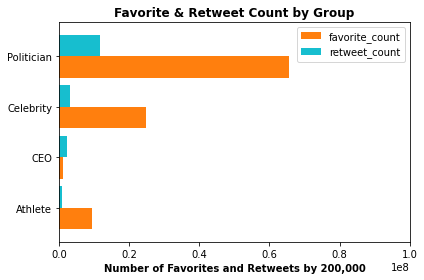

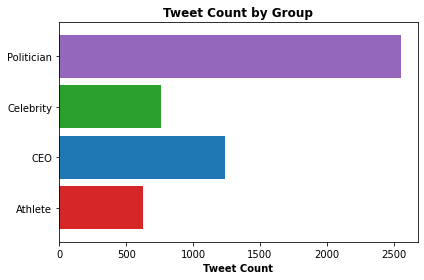

In [9]:
totals_df=cov_df.copy()
group = totals_df.groupby(by=['group'], as_index=False)

totals_df= group.aggregate({
    "id_str":"count",
    "favorite_count":"sum",
    "retweet_count":"sum"
})
totals_df= totals_df.rename(columns={"id_str":"tweet_count"})
totals_df

width=0.85
# plt.figure(figsize=(16,5))
# plt.subplot(1,2,1)
totals_df.plot.barh(x="group", y=["favorite_count", "retweet_count"], width=width, color=["tab:orange","tab:cyan"])
plt.xlabel("Number of Favorites and Retweets by 200,000", fontweight='bold')
plt.ylabel("", rotation="horizontal", fontweight='bold')
plt.xlim(0,100000000,10000000)
plt.title("Favorite & Retweet Count by Group", fontweight='bold')
plt.xticks(rotation="horizontal")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("Retweet_Favorite_Count_byGroup.png")
# plt.subplot(1,2,2)
totals_df.plot.barh(x="group", y="tweet_count", width=width, color=["tab:red","tab:blue","tab:green","tab:purple"], legend=None)
plt.ylabel("", rotation="horizontal", fontweight='bold')
plt.xlabel("Tweet Count", fontweight='bold')
plt.title("Tweet Count by Group", fontweight='bold')
plt.xticks(rotation="horizontal")
plt.tight_layout()
# plt.legend(loc="best")
plt.savefig("Tweet_Count_byGroup.png")

Text(0, 0.5, '')

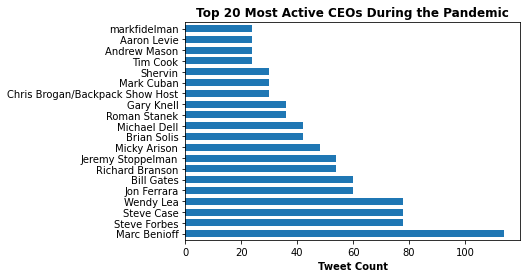

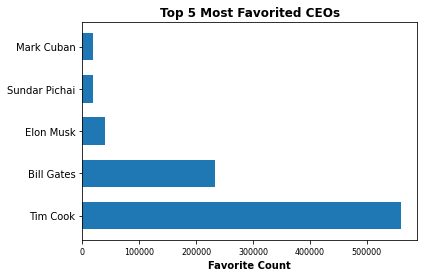

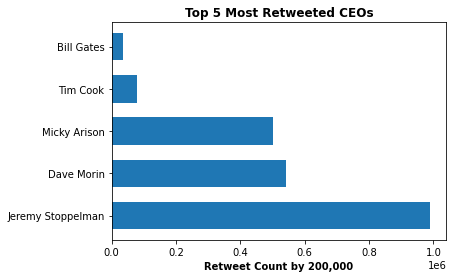

In [10]:
CEO_df=cov_df.copy()
CEO_df = CEO_df.loc[CEO_df["group"]=="CEO"]

group1 = CEO_df.groupby(by=["name","group"], as_index=False)

CEO_df = group1.aggregate({
    "id_str":"count",
    "favorite_count":"sum",
    "retweet_count":"sum"
})
CEO_df = CEO_df.rename(columns={"id_str":"tweet_count"})
CEO_tw = CEO_df.sort_values(by="tweet_count", ascending=False).iloc[:20]
CEO_fav = CEO_df.sort_values(by="favorite_count", ascending=False).iloc[0:5]
CEO_RT = CEO_df.sort_values(by="retweet_count", ascending=False).iloc[0:5]

# plt.figure(figsize=(50,15)) # plot the figure and set figure size
# plt.subplot(1,3,1)
width=0.65
CEO_tw.plot.barh(x="name", y="tweet_count", width=width, color=["tab:blue"], legend=None)
plt.title("Top 20 Most Active CEOs During the Pandemic", fontweight="bold")
plt.xlabel("Tweet Count", fontweight="bold")
plt.ylabel("")
# plt.xticks(fontsize=8)
# plt.tight_layout()

width=0.65
CEO_fav.plot.barh(x="name", y="favorite_count", width=width, color=["tab:blue"], legend=None)
plt.title("Top 5 Most Favorited CEOs", fontweight="bold")
plt.xlabel("Favorite Count", fontweight="bold")
plt.ylabel("")
plt.xticks(fontsize=8)
# plt.tight_layout()

xs = CEO_df.sort_values(by="retweet_count")
x_ticks = [d for d in xs["retweet_count"]]
width=0.65
CEO_RT.plot.barh(x="name", y="retweet_count", width=width, color=["tab:blue"], legend=None)
plt.title("Top 5 Most Retweeted CEOs", fontweight="bold")
plt.xlabel("Retweet Count by 200,000", fontweight="bold")
plt.ylabel("")
# plt.xlim(0, 1000000, 100000)
# plt.tight_layout()

In [11]:
CEO_df

,name,group,tweet_count,favorite_count,retweet_count
0,Aaron Levie,CEO,24,17628,1092
1,Andrew Mason,CEO,24,0,0
2,Bill Gates,CEO,60,233436,36582
3,Bill Gross,CEO,12,828,240
4,Brian Halligan,CEO,24,36,144
5,Brian Solis,CEO,42,498,144
6,Bryan Kramer - Keynote Speaker,CEO,24,30,24
7,Chris Brogan/Backpack Show Host,CEO,30,270,210
8,Daniel Ek,CEO,12,2160,300
9,Dave Morin,CEO,18,354,542016


Text(0, 0.5, '')

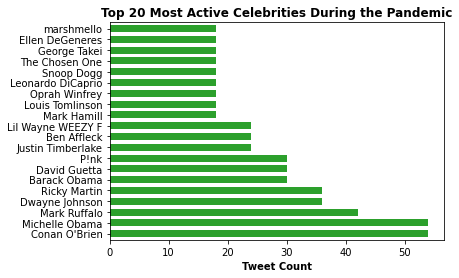

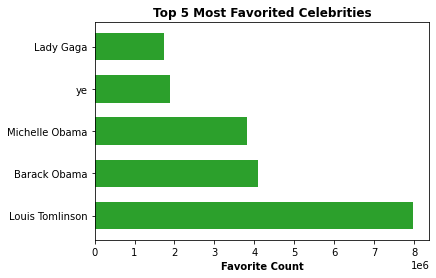

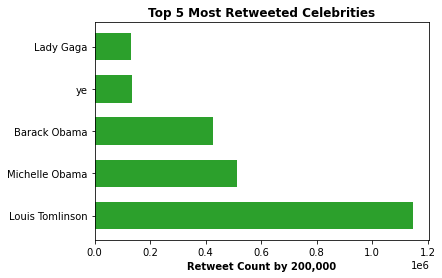

In [12]:
Celebrity_df=cov_df.copy()
Celebrity_df=Celebrity_df.loc[Celebrity_df["group"]=="Celebrity"]

group2 = Celebrity_df.groupby(by=["name", "group"], as_index=False)

Celebrity_df = group2.aggregate({
    "id_str":"count",
    "favorite_count":"sum",
    "retweet_count":"sum"
})
Celebrity_df = Celebrity_df.rename(columns={"id_str":"tweet_count"})
Celebrity_tw = Celebrity_df.sort_values(by="tweet_count", ascending=False).iloc[:20]
Celebrity_fav = Celebrity_df.sort_values(by="favorite_count", ascending=False).iloc[0:5]
Celebrity_RT = Celebrity_df.sort_values(by="retweet_count", ascending=False).iloc[0:5]


width=0.65
Celebrity_tw.plot.barh(x="name", y="tweet_count", width=width, color=["tab:green"], legend=None)
plt.title("Top 20 Most Active Celebrities During the Pandemic", fontweight="bold")
plt.xlabel("Tweet Count", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()

width=0.65
Celebrity_fav.plot.barh(x="name", y="favorite_count", width=width, color=["tab:green"], legend=None)
plt.title("Top 5 Most Favorited Celebrities", fontweight="bold")
plt.xlabel("Favorite Count", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()

width=0.65
Celebrity_RT.plot.barh(x="name", y="retweet_count", width=width, color=["tab:green"], legend=None)
plt.title("Top 5 Most Retweeted Celebrities", fontweight="bold")
plt.xlabel("Retweet Count by 200,000", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()

In [13]:
Celebrity_df

,name,group,tweet_count,favorite_count,retweet_count
0,A.R.Rahman,Celebrity,12,36906,2496
1,Alicia Keys,Celebrity,12,0,17808
2,Barack Obama,Celebrity,30,4090716,425574
3,Ben Affleck,Celebrity,24,148524,32820
4,Casey Neistat,Celebrity,18,17676,984
5,Coldplay,Celebrity,18,13446,2472
6,Conan O'Brien,Celebrity,54,1360728,93390
7,David Guetta,Celebrity,30,12858,1494
8,Demi Lovato,Celebrity,6,43008,4530
9,Dwayne Johnson,Celebrity,36,228552,11142


Text(0, 0.5, '')

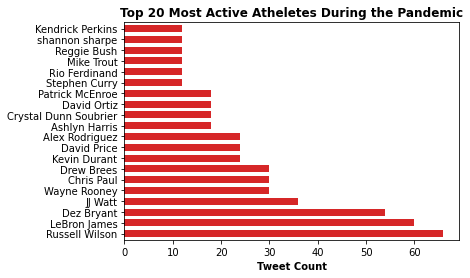

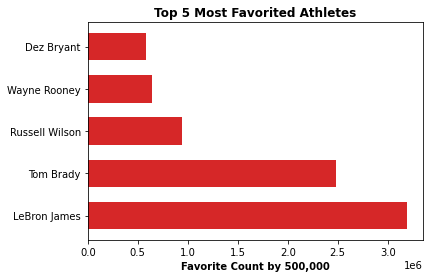

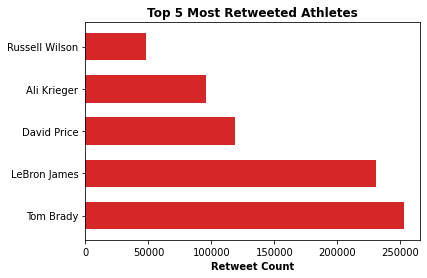

In [14]:
athletes_df=cov_df.copy()
athletes_df=athletes_df.loc[athletes_df["group"]=="Athlete"]

group3 = athletes_df.groupby(by=["name", "group"], as_index=False)

athletes_df= group3.aggregate({
    "id_str":"count",
    "favorite_count":"sum",
    "retweet_count":"sum"
})
athletes_df = athletes_df.rename(columns={"id_str":"tweet_count"})
athletes_tw = athletes_df.sort_values(by="tweet_count", ascending=False).iloc[:20]
athletes_fav=athletes_df.sort_values(by="favorite_count", ascending=False).iloc[0:5]
athletes_ret=athletes_df.sort_values(by="retweet_count", ascending=False).iloc[0:5]
athletes_df

width=0.65
athletes_tw.plot.barh(x="name", y="tweet_count", width=width, color=["tab:red"], legend=None)
plt.title("Top 20 Most Active Atheletes During the Pandemic", fontweight="bold")
plt.xlabel("Tweet Count", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()


width=0.65
athletes_fav.plot.barh(x="name", y="favorite_count", width=width,  color=["tab:red"], legend=None)
plt.title("Top 5 Most Favorited Athletes", fontweight="bold")
plt.xlabel("Favorite Count by 500,000", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()
# plt.show()

width=0.65
athletes_ret.plot.barh(x="name", y="retweet_count", width=width, color=["tab:red"], legend=None)
plt.title("Top 5 Most Retweeted Athletes", fontweight="bold")
plt.xlabel("Retweet Count", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()

In [15]:
athletes_df

,name,group,tweet_count,favorite_count,retweet_count
0,Aaron Rodgers,Athlete,6,96846,5994
1,Alex Ovechkin,Athlete,6,14856,1446
2,Alex Rodriguez,Athlete,24,6558,384
3,Ali Krieger,Athlete,6,0,95364
4,Ali Riley,Athlete,6,24,0
5,Ashlyn Harris,Athlete,18,21504,1830
6,Baker Mayfield,Athlete,12,360714,15576
7,Chris Paul,Athlete,30,110622,10422
8,Colin Kaepernick,Athlete,7,3598,595
9,Conor McGregor,Athlete,12,197022,12564


Text(0, 0.5, '')

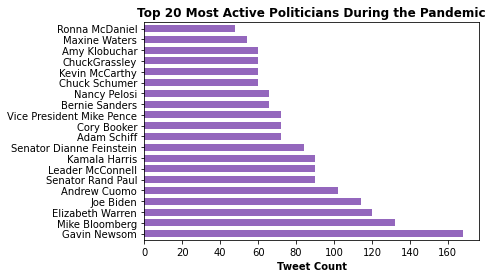

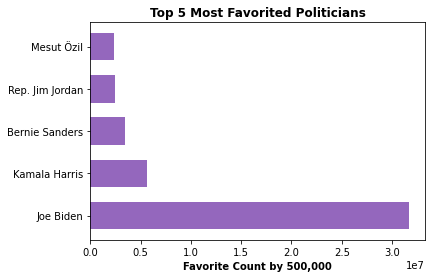

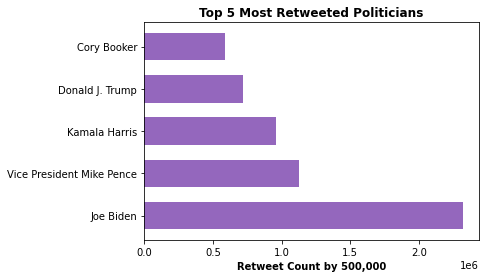

In [16]:
politicians_df=cov_df.copy()
politicians_df=politicians_df.loc[politicians_df["group"]=="Politician"]

group4 = politicians_df.groupby(by=["name","group"], as_index=False)

politicians_df= group4.aggregate({
    "id_str":"count",
    "favorite_count":"sum",
    "retweet_count":"sum"
})
politicians_df = politicians_df.rename(columns={"id_str":"tweet_count"})
politicians_tw= politicians_df.sort_values(by="tweet_count", ascending=False).iloc[:20]
politicians_fav=politicians_df.sort_values(by="favorite_count", ascending=False).iloc[0:5]
politicians_ret=politicians_df.sort_values(by="retweet_count", ascending=False).iloc[0:5]
politicians_df

width=0.65
politicians_tw.plot.barh(x="name", y="tweet_count", width=width, color=["tab:purple"], legend=None)
plt.title("Top 20 Most Active Politicians During the Pandemic", fontweight="bold")
plt.xlabel("Tweet Count", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()


width=0.65
politicians_fav.plot.barh(x="name", y="favorite_count", width=width,  color=["tab:purple"], legend=None)
plt.title("Top 5 Most Favorited Politicians", fontweight="bold")
plt.xlabel("Favorite Count by 500,000", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()
# plt.show()

width=0.65
politicians_ret.plot.barh(x="name", y="retweet_count", width=width, color=["tab:purple"], legend=None)
plt.title("Top 5 Most Retweeted Politicians", fontweight="bold")
plt.xlabel("Retweet Count by 500,000", fontweight="bold")
plt.ylabel("", fontweight="bold")
# plt.xticks(fontsize=8)
# plt.tight_layout()

In [17]:
politicians_df

,name,group,tweet_count,favorite_count,retweet_count
0,Adam Schiff,Politician,72,2227368,442284
1,Al Franken,Politician,36,416232,44826
2,Allen West,Politician,18,0,1128
3,Amy Klobuchar,Politician,60,77676,12300
4,Andrew Cuomo,Politician,102,863928,74874
5,Arnold,Politician,18,121704,11076
6,Bernie Sanders,Politician,66,3405096,452346
7,Beto O'Rourke,Politician,18,289116,437664
8,Chris Murphy,Politician,48,44214,10476
9,Chuck Schumer,Politician,60,207276,28710


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

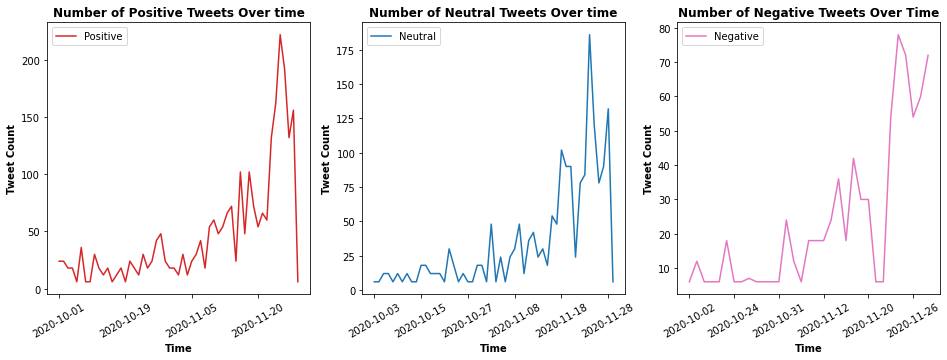

In [18]:
cov_df
def cleanTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    return txt
cov_df["text"] = cov_df["text"].apply(cleanTweet)

def getSubjectivity(txt):
    return TextBlob(txt).sentiment.subjectivity

def getPolarity(txt):
    return TextBlob(txt).sentiment.polarity

cov_df["Subjectivity"] = cov_df["text"].apply(getSubjectivity)
cov_df["Polarity"] = cov_df["text"].apply(getPolarity)


# negative, nautral, positive analysis
def getSentiment(a):
    if a < 0:
        return "Negative"
    elif a == 0:
        return "Neutral"
    else:
        return "Positive"
    
cov_df["Sentiment"] = cov_df["Polarity"].apply(getSentiment)

# # Gets twitter date in datetime format
# def get_datetime(date):
#     # Uses lambda to substitute twitter data format to only spaces
#     remove_end = lambda x:re.sub("\+\d+\s","",x)
#     # Removes the end of the twitter date form and creates into datetime form
#     make_dt = lambda x:datetime.strptime(remove_end(x), "%a %b %d %H:%M:%S %Y")
#     # Creates specific format for data
#     my_format = lambda x:"{:%Y-%m-%d}".format(make_dt(x))
#     # every twitter created_at date will have datetime format
#     dtime=my_format(date)
#     return dtime

# df["date"] = df["created_at"].apply(get_datetime)

group=cov_df.groupby(["Sentiment"])
# Counts each tweets for each date and sums each retweet count for each date
sentiment_df=group.aggregate({
    "Sentiment":"count"    
})
sentiment_df=sentiment_df.rename(columns={"Sentiment":"tweet_count"}).reset_index()

group=cov_df.groupby(["date","Sentiment"])
new_df=group.aggregate({
    "date":"count"
})
new_df=new_df.rename(columns={"date":"tweet_count"}).reset_index()
# new_df


# # Creates figure size for plots
plt.figure(figsize=(16,5), facecolor=None)
# # Creates 2 subplots, this figure being in first plot
plt.subplot(1,3,1)

# # positive_count=df["Sentiment"].loc[df["Sentiment"]=="Positive"]
# # positive_count

plt.plot(new_df["date"].loc[new_df["Sentiment"]=="Positive"],new_df["tweet_count"].loc[new_df["Sentiment"]=="Positive"], label="Positive", color="tab:red")
plt.xticks(range(0,len(new_df["date"].loc[new_df["Sentiment"]=="Positive"]),15),rotation=30)
# Creates title, x label, y label and formats legend to best location on graph
plt.title("Number of Positive Tweets Over time", fontweight="bold")
plt.xlabel("Time", fontweight="bold")
plt.ylabel("Tweet Count", fontweight="bold")
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.plot(new_df["date"].loc[new_df["Sentiment"]=="Neutral"],new_df["tweet_count"].loc[new_df["Sentiment"]=="Neutral"], label="Neutral", color="tab:blue")
plt.xticks(range(0,len(new_df["date"].loc[new_df["Sentiment"]=="Neutral"]),10),rotation=30)
# Creates title, x label, y label and formats legend to best location on graph
plt.title("Number of Neutral Tweets Over time", fontweight="bold")
plt.xlabel("Time", fontweight="bold")
plt.ylabel("Tweet Count", fontweight="bold")
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.plot(new_df["date"].loc[new_df["Sentiment"]=="Negative"],new_df["tweet_count"].loc[new_df["Sentiment"]=="Negative"], label="Negative", color="tab:pink")
plt.xticks(range(0,len(new_df["date"].loc[new_df["Sentiment"]=="Negative"]),6),rotation=30)
# Creates title, x label, y label and formats legend to best location on graph
plt.title("Number of Negative Tweets Over Time", fontweight="bold")
plt.xlabel("Time", fontweight="bold")
plt.ylabel("Tweet Count", fontweight="bold")
plt.legend(loc="best")

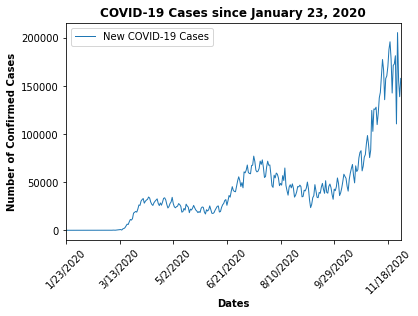

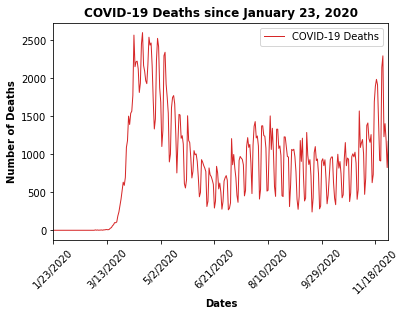

In [19]:
cases_df=pd.read_csv("global_confirmed_cases.csv")
deaths_df=pd.read_csv("global_deaths.csv")
US_cases=cases_df.US
US_deaths=deaths_df.US
US_Dates=cases_df.Date

COVID_df=pd.DataFrame(data={"Date":US_Dates, "New COVID-19 Cases":US_cases, "COVID-19 Deaths":US_deaths})
# COVID_df

COVID_df.plot(x="Date", y=["New COVID-19 Cases"], rot=45, color='tab:blue', linewidth=1)
plt.title("COVID-19 Cases since January 23, 2020", fontweight="bold")
plt.ylabel("Number of Confirmed Cases", fontweight="bold")
plt.xlabel("Dates", fontweight="bold")
COVID_df.plot(x="Date", y=["COVID-19 Deaths"], rot=45, color='tab:red', linewidth=1)
plt.title("COVID-19 Deaths since January 23, 2020", fontweight="bold")
plt.ylabel("Number of Deaths", fontweight="bold")
plt.xlabel("Dates", fontweight="bold")
# COVID_df.to_excel("US_COVID-19.xlsx")


In [193]:
new_df
COVID_df

cases=COVID_df["New COVID-19 Cases"]
deaths=COVID_df["COVID-19 Deaths"]
pos=new_df["tweet_count"].loc[new_df["Sentiment"]=="Positive"]
neg=new_df["tweet_count"].loc[new_df["Sentiment"]=="Negative"]
neu=new_df["tweet_count"].loc[new_df["Sentiment"]=="Neutral"]

# COVID Cases Correlation
pos_cases_corr=cases.corr(pos)
print(f"Positive Sentiment and COVID-19 Cases Correlation: {pos_cases_corr}")
print("------------------------------------------------------------------------")
neg_cases_corr=cases.corr(neg)
print(f"Negative Sentiment and COVID-19 Cases Correlation: {neg_cases_corr}")
print("------------------------------------------------------------------------")
neu_cases_corr=cases.corr(neu)
print(f"Neutral Sentiment and COVID-19 Cases Correlation: {neu_cases_corr}")
print("------------------------------------------------------------------------")
# COVID Deaths Correlation
pos_deaths_corr=deaths.corr(pos)
print(f"Positive Sentiment and COVID-19 Deaths Correlation: {pos_deaths_corr}")
print("------------------------------------------------------------------------")
neg_deaths_corr=deaths.corr(neg)
print(f"Negative Sentiment and COVID-19 Deaths Correlation: {neg_deaths_corr}")
print("------------------------------------------------------------------------")
neu_deaths_corr=deaths.corr(neu)
print(f"Neutral Sentiment and COVID-19 Deaths Correlation: {neu_deaths_corr}")

Positive Sentiment and COVID-19 Cases Correlation: 0.4285877834628595
------------------------------------------------------------------------
Negative Sentiment and COVID-19 Cases Correlation: 0.4107805278865924
------------------------------------------------------------------------
Neutral Sentiment and COVID-19 Cases Correlation: 0.4332843631006731
------------------------------------------------------------------------
Positive Sentiment and COVID-19 Deaths Correlation: 0.3019833140206021
------------------------------------------------------------------------
Negative Sentiment and COVID-19 Deaths Correlation: 0.22232472667053338
------------------------------------------------------------------------
Neutral Sentiment and COVID-19 Deaths Correlation: 0.30690298361029017


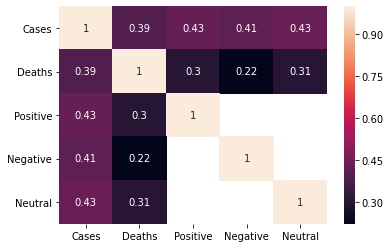

In [184]:
data = {'Cases':COVID_df["New COVID-19 Cases"],
             'Deaths':COVID_df["COVID-19 Deaths"],
             'Positive':new_df["tweet_count"].loc[new_df["Sentiment"]=="Positive"],
             'Negative':new_df["tweet_count"].loc[new_df["Sentiment"]=="Negative"],
             'Neutral':new_df["tweet_count"].loc[new_df["Sentiment"]=="Neutral"]}
corr_df = pd.DataFrame(data, columns=['Cases','Deaths','Positive','Negative','Neutral'])
corrMatrix = corr_df.corr()
sn.heatmap(corrMatrix, annot=True)

In [164]:
# def crawl_tweet(file_name="raw_tweet.json", search_key="Twitter", max_tweet=200):
#     tweet_count=0
#     max_id=-1
#     print(search_key)
#     with open(file_name, "w") as fp: # overwrite old data
#         fp.write("")
#     while tweet_count<max_tweet:
#         try:
#             # tweet crawling
            
#             if max_id<0:
#                 new_tweets=api.search(q=search_key, count=50)
#             else:
#                 new_tweets=api.search(q=search_key, count=50, max_id=str(max_id-1))
#             if not new_tweets:
#                 print("no more tweets available")
#                 break
#             with open(file_name, "a") as fp:
#                 for tweet in new_tweets:
#                     fp.write(json.dumps(tweet._json)+"\n")
#             max_id=new_tweets[-1].id
#             tweet_count+=len(new_tweets)
#             print(f"{tweet_count} tweets have been downloaded")
#         except tweepy.TweepError as e:
#             print(str(e))
#             break

# crawl_tweet(file_name="COVID-19.json",search_key="\"Coronavirus\"", max_tweet=300)

In [165]:
# COVID19=load_json("COVID-19.json")
# df_training=pd.DataFrame(data=COVID19)
# df_training["Subjectivity"] = df_training["text"].apply(getSubjectivity)
# df_training["Polarity"] = df_training["text"].apply(getPolarity)
# df_training["Sentiment"] = df_training["Polarity"].apply(getSentiment)
# df_training
# sentiment_list=[]
# df_training=pd.read_csv("corona_tweets_01.csv")
# for d in df_training["Sentiment Score"]:
#     if d > 0:
#         Sentiment="Positive"
#     elif d < 0:
#         Sentiment="Negative"
#     else:
#         Sentiment="Neutral"
#     sentiment_list.append(Sentiment)
# df_training["Sentiment"]=sentiment_list
# cov_df


In [166]:
# cov_df
# # df_training = pd.read_excel("training_data2.xlsx")

# def text2tokens(text):
#     text=re.sub(r"http.+|@\w+|#\w+|RT|&\w", "", text)
#     tokens=word_tokenize(text)
#     tokens=[w.lower() for w in tokens if w.lower() not in stop_words and len(w)>3]
#     tokens=[lemmatizer.lemmatize(t) for t in tokens]
# #     tokens=[stemmer.stem(t) for t in tokens]
#     return tokens


# cov_df["tokens"]=cov_df.text.apply(text2tokens)
# df_training["tokens"]=df_training.text.apply(text2tokens)

In [167]:
# class KNNClassifier:
#     def __init__(self, K=10):
#         self.K=K
 
#     def convert_to_vector(self,words):
#         return [words.count(d) for d in self.dictionary]
    
#     def cosine_sim(self,a,b):
# #         print(np.linalg.norm(a)*np.linalg.norm(b))
#         return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    
#     def train(self, tokens_list, tags):
#         dictionary = gensim.corpora.Dictionary(tokens_list)
#         dictionary.filter_extremes(no_below=10, no_above=len(tokens_list)*0.6, keep_n=1000)
#         self.dictionary=[v for k, v in dictionary.iteritems()]
        
#         vectors=[self.convert_to_vector(tokens) for tokens in tokens_list]
#         self.vectors_df=pd.DataFrame(data={
#             "vector":vectors,
#             "tag":tags
#         })
        
#     def predict(self, tokens):
#         test_vector=self.convert_to_vector(tokens)
#         distances=[self.cosine_sim(vector,test_vector) for vector in self.vectors_df.vector]
#         self.vectors_df["distance"]=distances
#         sorted_list=self.vectors_df.sort_values(by="distance", ascending=False).iloc[:self.K]
#         pos_neg_neu_count=sorted_list.groupby(by="tag").tag.count()
#         if "Positive" in pos_neg_neu_count:
#             pos_count=pos_neg_neu_count["Positive"]
#         else:
#             pos_count=0
#         if "Neutral" in pos_neg_neu_count:
#             neu_count=pos_neg_neu_count["Neutral"]
#         else:
#             neu_count=0
#         if "Negative" in pos_neg_neu_count:
#             neg_count=pos_neg_neu_count["Negative"]
#         else:
#             neg_count=0
#         return pos_count/self.K, neu_count/self.K, neg_count/self.K
        
# knn_model=KNNClassifier(K=11)
# knn_model.train(df_training.tokens,df_training.Sentiment)

In [168]:
# predicts=[]
# correct_counter=0
# for index, row in cov_df.iterrows():
#     pos,neu,neg=knn_model.predict(row["tokens"])
#     if pos>neu and pos>neg:
#         prediction="Positive"
#     if neu>pos and neu>neg:
#         prediction="Neutral"
#     if neg>pos and neg>neu:
#         prediction="Negative"
#     cov_df.loc[index,"pos"]=pos
#     cov_df.loc[index,"neu"]=neu
#     cov_df.loc[index,"neg"]=neg
#     predicts.append(prediction)
#     if row["Sentiment"]==prediction:
#         correct_counter+=1
        
# print(correct_counter)   
# cov_df["prediction"]=predicts
# cov_df=cov_df.drop(columns=["created_at", "favorite_count", "hashtags", "mentions", "retweet_count", "screen_name", "text", "user_description", "user_followers_count", "user_friends_count", "user_id_str" "user_location", "tokens", "Subjectivity", "Polarity"])
# # cov_df=cov_df.reindex(columns=["id_str", "Sentiment", "prediction", "pos", "neu", "neg"])
# cov_df

In [169]:
# class NaiveBayesClassifier:
#     def __init__(self, k = 0.5):
#         self.k = k  
#         self.token_pos_counts = defaultdict(int) 
#         self.token_neu_counts = defaultdict(int)
#         self.token_neg_counts = defaultdict(int) 
#         self.pos_count = self.neg_count = self.neu_count = 0 
    
#     def train(self, tokens_list, tags):
#         dictionary = gensim.corpora.Dictionary(tokens_list)
#         dictionary.filter_extremes(no_below=10, no_above=len(tokens_list)*0.6, keep_n=1000)
#         word_dict=[v for k, v in dictionary.iteritems()]
#         self.dictionary=word_dict
        
#         self.vectors_df=pd.DataFrame(data={
#             "tokens":tokens_list,
#             "tag":tags
#         })
        
#         pos_df=self.vectors_df.loc[self.vectors_df.tag=="positive"]
#         neu_df=self.vectors_df.loc[self.vectors_df.tag=="neutral"]
#         neg_df=self.vectors_df.loc[self.vectors_df.tag=="negative"]
#         self.pos_count=len(pos_df)
#         self.neu_count=len(neu_df)
#         self.neg_count=len(neg_df)        
        
#         for index,row in self.vectors_df.iterrows():
#             for keyword in word_dict:
#                 if keyword in row["tokens"]:
#                     if row["tag"]=="positive":
#                         self.token_pos_counts[keyword]+=1
#                     elif row["tag"]=="neutral":
#                         self.token_neu_counts[keyword]+=1
#                     else:
#                         self.token_neg_counts[keyword]+=1   
# #         print(self.token_pos_counts)
# #         print(self.token_neu_counts)
# #         print(self.token_neg_counts)

#     def probabilities(self, token):
#         pos = self.token_pos_counts[token]
#         neu = self.token_neu_counts[token]
#         neg = self.token_neg_counts[token]
#         p_token_pos = (pos + self.k) / (self.pos_count + 2 * self.k)
#         p_token_neu = (neu + self.k) / (self.neu_count + 2 * self.k)
#         p_token_neg = (neg + self.k) / (self.neg_count + 2 * self.k)
#         return p_token_pos, p_token_neu, p_token_neg
    
#     def predict(self, tokens):
#         log_prob_if_pos = log_prob_if_neg = log_prob_if_neu = 0
        
#         for token in self.dictionary:
#             p_if_pos, p_if_neu, p_if_neg = self.probabilities(token)
#             if token in tokens:
#                 log_prob_if_pos += math.log(p_if_pos)
#                 log_prob_if_neu += math.log(p_if_neu)
#                 log_prob_if_neg += math.log(p_if_neg)
#             else:
#                 log_prob_if_pos += math.log(1 - p_if_pos)
#                 log_prob_if_neu += math.log(1 - p_if_neu)
#                 log_prob_if_neg += math.log(1 - p_if_neg)
                
#         sent_count=self.pos_count+self.neg_count+self.neg_count
#         pro_if_pos=math.exp(log_prob_if_pos) * (self.pos_count/sent_count)
#         pro_if_neu=math.exp(log_prob_if_neu) * (self.neu_count/sent_count)
#         pro_if_neg=math.exp(log_prob_if_neg) * (self.neg_count/sent_count)
#         return pro_if_pos/(pro_if_pos+pro_if_neu+pro_if_neg), pro_if_neu/(pro_if_pos+pro_if_neu+pro_if_neg), pro_if_neg/(pro_if_pos+pro_if_neu+pro_if_neg)

# nb_model = NaiveBayesClassifier(k=0.5)
# nb_model.train(df_training.tokens, df_training.Sentiment)      

In [170]:
# predicts=[]
# correct_counter=0
# for index, row in cov_df.iterrows():
#     pos,neu,neg=nb_model.predict(row["tokens"])
#     if pos>neu and pos>neg:
#         prediction="positive"
#     if neu>pos and neu>neg:
#         prediction="neutral"
#     if neg>pos and neg>neu:
#         prediction="negative"
#     df_testing.loc[index,"pos"]=pos
#     df_testing.loc[index,"neu"]=neu
#     df_testing.loc[index,"neg"]=neg
#     predicts.append(prediction)
#     if row["Sentiment"]==prediction:
#         correct_counter+=1
        
# print(correct_counter)
# cov_df["prediction"]=predicts
# cov_df

In [171]:
# COVID19=load_json("COVID-19.json")
# df_training=pd.DataFrame(data=COVID19)
# df_training["Subjectivity"] = df_training["text"].apply(getSubjectivity)
# df_training["Polarity"] = df_training["text"].apply(getPolarity)
# df_training["Sentiment"] = df_training["Polarity"].apply(getSentiment)
# df_training

In [172]:
# def preprocess_tweet_text(tweet):
#     tweet.lower()
#     # Remove urls
#     tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
#     # Remove user @ references and '#' from tweet
#     tweet = re.sub(r'\@\w+|\#','', tweet)
#     # Remove punctuations
#     tweet = tweet.translate(str.maketrans('', '', string.punctuation))
#     # Remove stopwords
#     tweet_tokens = word_tokenize(tweet)
#     filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
#     ps = PorterStemmer()
#     stemmed_words = [ps.stem(w) for w in filtered_words]
# #     lemmatizer = WordNetLemmatizer()
# #     lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
#     return " ".join(filtered_words)

# def get_feature_vector(train_fit):
#     vector = TfidfVectorizer(sublinear_tf=True)
#     vector.fit(train_fit)
#     return vector

# def int_to_string(sentiment):
#     if sentiment == 0:
#         return "Negative"
#     elif sentiment == 2:
#         return "Neutral"
#     else:
#         return "Positive"
    
    

In [173]:
# cov_df

In [174]:
# cov_df["tokens"]=cov_df.text.apply(text2tokens)
# df_training["tokens"]=df_training.text.apply(text2tokens)
# df_training["Subjectivity"] = df_training["text"].apply(getSubjectivity)
# df_training["Polarity"] = df_training["text"].apply(getPolarity)
# df_training["Sentiment"] = df_training["Polarity"].apply(getSentiment)
# df_training

In [175]:
# df_training.text=df_training["text"].apply(preprocess_tweet_text)

# # df_training

# # Remove unwanted columns from dataset
# # cov_df = cov_df.drop(columns=[""])
# #Preprocess data
# # dataset.text = dataset['text'].apply(preprocess_tweet_text)
# # Split dataset into Train, Test

# # Same tf vector will be used for Testing sentiments on unseen trending data
# tf_vector = get_feature_vector(np.array(df_training.iloc[:, 1]).ravel())
# X = tf_vector.transform(np.array(df_training.iloc[:, 1]).ravel())
# y = np.array(df_training.iloc[:, 0]).ravel()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# # Training Naive Bayes model
# NB_model = MultinomialNB()
# NB_model.fit(X_train, y_train)
# y_predict_nb = NB_model.predict(X_test)
# print(accuracy_score(y_test, y_predict_nb))

# # Training Logistics Regression model
# LR_model = LogisticRegression(solver='lbfgs')
# LR_model.fit(X_train, y_train)
# y_predict_lr = LR_model.predict(X_test)
# print(accuracy_score(y_test, y_predict_lr))

In [176]:
# class PreProcessTweets:
#     def __init__(self):
#         self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])
        
#     def processTweets(self, list_of_tweets):
#         processedTweets=[]
#         for tweet in list_of_tweets:
#             processedTweets.append((self._processTweet(tweet["text"]),tweet["label"]))
#         return processedTweets
#     def _processTweet(self, tweet):
#         tweet = tweet.lower()
#         tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet)
#         tweet = re.sub('@[^\s]+', 'AT_USER', tweet)
#         tweet = re.sub(r'#[^\s]+)', r'\1', tweet)
#         tweet = word_tokenize(tweet)
#         return [word for word in tweet if word not in self._stopwords]
    
# tweetProcessor = PreProcessTweets()
# preprocessedTrainingData = tweetProcessor.processTweets(df_training)
# preprocessedTestData = tweetProcessor.processTweets(cov_df)
